In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
from pymgrit.core.application import Application
from pymgrit.core.vector import Vector
from pymgrit.core.simple_setup_problem import simple_setup_problem

from mpi4py import MPI
from pymgrit.core.mgrit import Mgrit

import pathlib
from random import randrange

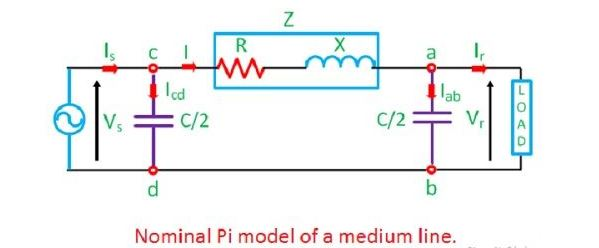

This system can be represented in the matrix form.
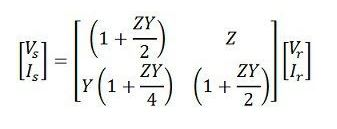

In [19]:
class VectorPiLine(Vector):
    """
    Vector for the PiLine model problem
    """

    def __init__(self):
        super().__init__()
        # Values of V,I at the nodes and the error function/state variables
        self.value = np.array([np.zeros(6),np.zeros((3,1))],dtype=object)

    def set_values(self, value):
        self.value  = value
        

    def get_values(self):
        return self.value

    def clone(self):
        tmp = VectorPiLine()
        tmp.set_values(self.get_values())
        return tmp

    def clone_zero(self):
        return VectorPiLine()

    def clone_rand(self):
        tmp = VectorPiLine()
        tmp.set_values(np.array([[np.random.rand(6)],[np.random.rand(3,1)]]))
        return tmp

    def __add__(self, other):
        tmp = VectorPiLine()
        tmp.set_values(self.get_values() + other.get_values())
        return tmp

    def __sub__(self, other):
        tmp = VectorPiLine()
        tmp.set_values(self.get_values() - other.get_values())
        return tmp

    def __mul__(self, other):
        tmp = VectorPiLine()
        tmp.set_values(self.get_values() * other)
        return tmp

    def norm(self):
        arr1 = np.array([np.array(self.value[0]) ,np.reshape(self.value[1],(3))],dtype=object)
        return np.linalg.norm(np.concatenate((arr1[0],arr1[1])))

    def pack(self):
        return self.value

    def unpack(self, value):
        self.value = value
        
        
def PiLine(dt,CP):
        
        # Constant Parameters
        #CP = np.array([100, 1, 1, 0.2, 1, 1, 5])
        Vs = CP[0]
        Rs = CP[1]
        C1 = CP[2]
        R1 = CP[3]
        L1 = CP[4]
        C2 = CP[5]
        R2 = CP[6]
        
        # Conductance matrix stamp values
        gVs = 1/Rs
        gR1 = 1/R1
        gR2 = 1/R2

        gC1_BE = C1/dt
        gC2_BE = C2/dt
        gL1_BE = dt/L1
        
        # Setup conductance matrix
        G_BE = np.matrix([ [gVs+gC1_BE+gR1,-gR1,0],[-gR1,gR1+gL1_BE,-gL1_BE],[0,-gL1_BE,gL1_BE+gC2_BE+gR2 ]],dtype=float)
        
        G_BEinv = G_BE.I
        
        return G_BEinv

In [20]:
class PiLineModel(Application):

    """
    Application class for the piline problem,
    Time 0.1 - 20.0 secs with nt = 200
    """
    
    def __init__(self,*args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.vector_template = VectorPiLine()
        self.vector_t_start = VectorPiLine()

        # Constant Parameters -> {Vs,Rs,C1,R1,L1,C2,R2}
        self.CP = np.array([100, 1, 1, 0.2, 1, 1, 5],dtype=float)
        
        init_val = np.array([np.array([0,(self.CP[0]/self.CP[1]),0,0,0,0]),np.zeros((3,1))],dtype=object)
        
        # Set initial condition 
        self.vector_t_start.set_values(init_val)

        # Source vector
        self.B_BE = np.zeros((3,1))
             
    def step(self, u_start: VectorPiLine, t_start: float, t_stop: float) -> VectorPiLine:
        
        dt = (t_stop-t_start)
        
        # Inverse of Conductance matrix
        self.G_BEinv = PiLine(dt,self.CP)
        
        tmp = u_start.get_values()
        #print('Get values: ',tmp)
        vC1_BE = tmp[0][0]
        iC1_BE = tmp[0][1]
        vC2_BE = tmp[0][2]
        iC2_BE = tmp[0][3]
        vL1_BE = tmp[0][4]
        iL1_BE = tmp[0][5]
        e_BE   = tmp[1]
        
        # Backward euler
        # voltage and current through linear differential elements

        iC1_BE = ((self.CP[2]/dt)*(e_BE[0]) - (self.CP[2]/dt)*vC1_BE)
        vC1_BE = e_BE[0]
        iC2_BE = ((self.CP[5]/dt)*(e_BE[2]) - (self.CP[5]/dt)*vC2_BE)
        vC2_BE = e_BE[2]
        vL1_BE = ((e_BE[1]) - (e_BE[2]))
        iL1_BE = ((dt/self.CP[4])*vL1_BE + iL1_BE)
        
        # non-constant source vector stamp for linear elements
        # Backward Euler
        bC1 = (self.CP[2]/dt)*vC1_BE
        bC2 = (self.CP[5]/dt)*vC2_BE
        bL1 = -iL1_BE
        
        # setup source vector
        self.B_BE = np.array([[(self.CP[0]/self.CP[1])+bC1+0],[0+bL1], [-bL1+bC2+0 ]])
        self.B_BE = np.reshape(self.B_BE,(3,1))
        
        
        # Update new guess for e
        e_BE = self.G_BEinv*self.B_BE
        
        ret_val = np.array([np.asarray([vC1_BE,iC1_BE,vC2_BE,iC2_BE,vL1_BE,iL1_BE[0]],dtype=float),np.asarray(e_BE)],dtype=object)
        
        u_stop = VectorPiLine()
        
        u_stop.set_values(ret_val)
        
        return u_stop

INFO - 30-05-22 19:38:09 - Start setup
INFO - 30-05-22 19:38:09 - Setup took 0.017906904220581055 s
INFO - 30-05-22 19:38:09 - Start solve
INFO - 30-05-22 19:38:09 - iter 1  | conv: 21.444751305074185      | conv factor: -                     | runtime: 0.3023362159729004 s   
INFO - 30-05-22 19:38:10 - iter 2  | conv: 3.4565460421960092      | conv factor: 0.16118377839980513   | runtime: 0.15002870559692383 s  
INFO - 30-05-22 19:38:10 - iter 3  | conv: 0.5580719101292393      | conv factor: 0.16145363125980108   | runtime: 0.15053462982177734 s  
INFO - 30-05-22 19:38:11 - iter 4  | conv: 0.10551884669495354     | conv factor: 0.18907750915203256   | runtime: 0.1405949592590332 s   
INFO - 30-05-22 19:38:11 - iter 5  | conv: 0.01802916512458853     | conv factor: 0.1708620373449436    | runtime: 0.1661231517791748 s   
INFO - 30-05-22 19:38:11 - iter 6  | conv: 0.0046470390974552795   | conv factor: 0.2577512084082893    | runtime: 0.15999078750610352 s  
INFO - 30-05-22 19:38:12 - 

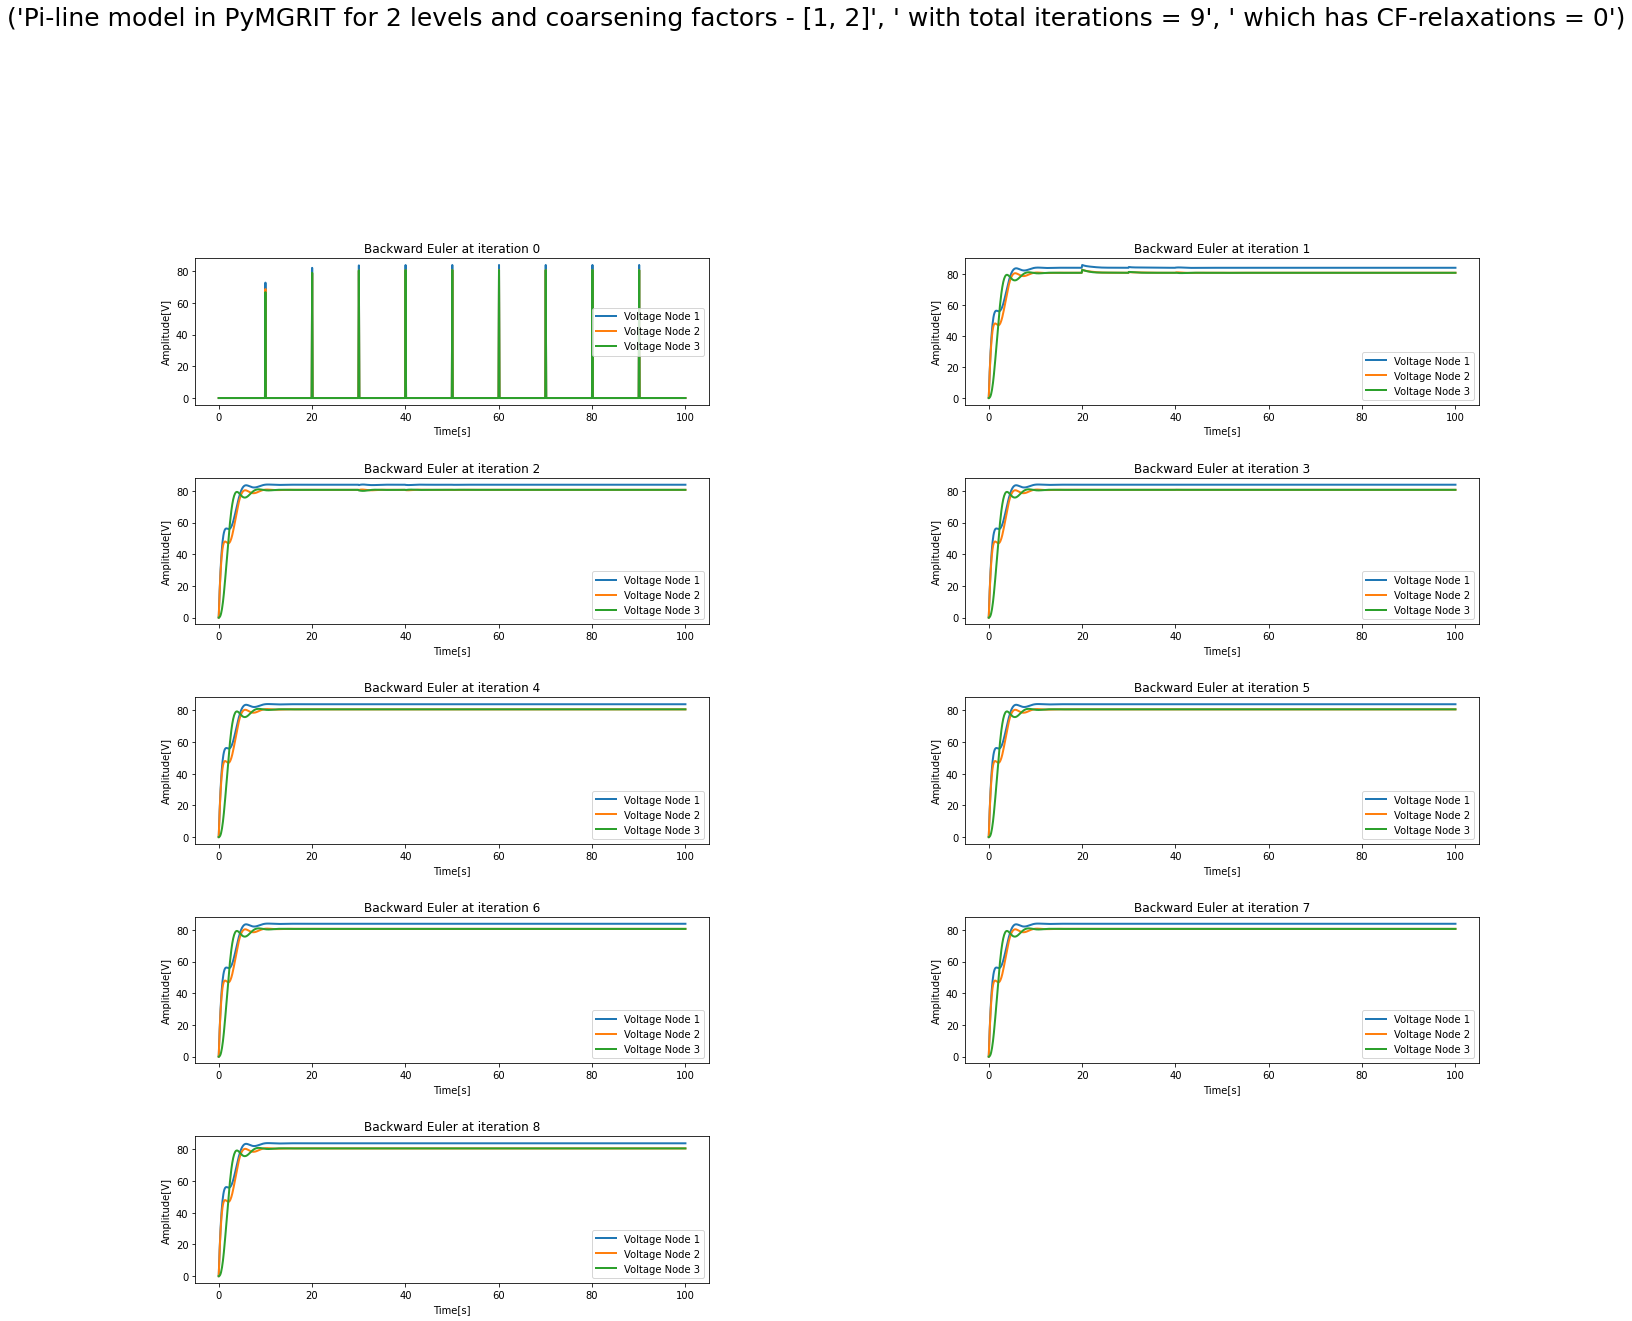

In [22]:
def main():
    
    def output_fcn(self):
    # Set path to solution; here, we include the iteration number in the path name
        path = 'results/' + 'Pilinemodel' + '/' + str(self.solve_iter)
    # Create path if not existing
        pathlib.Path(path).mkdir(parents=True, exist_ok=True)

    # Save solution to file.
    # Useful member variables of MGRIT solver:
    #   - self.t[0]           : local fine-grid (level 0) time interval
    #   - self.index_local[0] : indices of local fine-grid (level 0) time interval
    #   - self.u[0]           : fine-grid (level 0) solution values
    #   - self.comm_time_rank : Time communicator rank
        np.save(path + '/Pilinemodel-rank' + str(self.comm_time_rank),
                [[[self.t[0][i], self.u[0][i]] for i in self.index_local[0]]])  # Solution and time at local time points
    
    # Create multi-level time-grid hierarchy for the piline model system
    pilinemodel_lvl_0 = PiLineModel(t_start=0, t_stop=100, nt=1000)
    pilinemodel_lvl_1 = PiLineModel(t_interval=pilinemodel_lvl_0.t[::100])
    #pilinemodel_lvl_2 = PiLineModel(t_interval=pilinemodel_lvl_1.t[::10])
    #pilinemodel_lvl_3 = PiLineModel(t_interval=pilinemodel_lvl_2.t[::3])
    #pilinemodel_lvl_4 = PiLineModel(t_interval=pilinemodel_lvl_3.t[::4])

    # Set up the MGRIT solver for the desired levels and set the output function
    mgrit = Mgrit(problem=[pilinemodel_lvl_0, pilinemodel_lvl_1],tol=1e-10,output_fcn=output_fcn, output_lvl=2, cf_iter=0)
    
    #print('MGRIT Levels : ',mgrit)
    # Solve pi-line model system
    info = mgrit.solve()
    
    if MPI.COMM_WORLD.Get_rank() == 0:
        iterations_needed = len(info['conv'])+1
        
        plt.figure(1,figsize=(23,35))
        title_text = 'Pi-line model in PyMGRIT for '+ str(len(mgrit.problem)) + ' levels and coarsening factors - '+str([1,2]), ' with total iterations = '+str(iterations_needed),' which has CF-relaxations = '+str(mgrit.cf_iter) 
        plt.suptitle(title_text,fontsize=25)
        
        for i in range(iterations_needed):
            sol = []
            path = 'results/Pilinemodel'+'/'+str(i)
            for filename in os.listdir(path):
                data = np.load(path + '/'+ filename, allow_pickle=True).tolist()[0]
                sol += data
            sol.sort(key=lambda tup: tup[0])
        
        
        # Plot time and Amplitude of the solution
            t = np.linspace(pilinemodel_lvl_0.t_start,pilinemodel_lvl_0.t_end,pilinemodel_lvl_0.nt)
            eval_req = []
            for j in range(0, len(sol)):
                err_val = sol[j][1].get_values()
                eval_req.append(err_val[1])
            
            eval_req = np.transpose(np.squeeze(np.asarray(eval_req,dtype=float)))
             
            plt.subplot(iterations_needed,2,i+1)
            plt.plot(t, eval_req[0,:], t,eval_req[1,:],t,eval_req[2,:],linewidth=2)
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
            plt.legend(['Voltage Node 1','Voltage Node 2','Voltage Node 3'])
            plt.xlabel('Time[s]')
            plt.ylabel('Amplitude[V]')
            plt.title('Backward Euler at iteration '+str(i))           
        plt.savefig('results/Pilinemodel/Image '+str(randrange(25)))
        plt.show()
             

if __name__ == '__main__':
    #np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
    main()